# Laboratório 2 – Aprendizado de Máquina Probabilístico

**Instituto Tecnológico de Aeronáutica – ITA**

**Inteligência Artificial – CMC-15**

**Professores:** 

Paulo André Lima de Castro

Paulo Marcelo Tasinaffo

**Alunos:**

Alvaro Tedeschi Neto

Davi Muniz Vasconcelos

Gabriel Henrique Gobi

Thiago Lopes de Araujo

---

In [3]:
# for random decision of the tree criterias'
import random

# for calculating entropy
import math

# for data manipulation
import pandas as pd

# for train and test split
from sklearn.model_selection import train_test_split

# for confusion matrix
from sklearn.metrics import confusion_matrix

# for cohen's kappa coefficient
from sklearn.metrics import cohen_kappa_score

# for visualize the decision tree
from graphviz import Digraph
import pydot

# for amazing plots
import matplotlib.pyplot as plt
import seaborn as sns

## 2.1 Dataset

In `republican_democrat.txt` we have the following description of the data:

```
This data set includes votes for each of the U.S. House of Representatives Congressmen on the 16 key votes identified by the CQA.  The CQA lists nine different types of votes: voted for, paired for, and announced for (these three simplified to yea), voted against, paired against, and announced against (these three simplified to nay), voted present, voted present to avoid conflict of interest, and did not vote or otherwise make a position known (these three simplified to an unknown disposition).
``` 

Let's see how the data looks:

In [4]:
df = pd.read_csv("data/republican_democrat.csv")
print(f'The dataset has {df.shape[0]} entries')
df.head()

The dataset has 415 entries


,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Target
0,n,y,n,y,y,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,y,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,n,n,n,y,?,y,y,y,y,democrat


All features are ***categoric features***. The columns above represent, accordingly with the text document provided:

```
1. Class Name: 2 (democrat, republican)
2. handicapped-infants: 2 (y,n)
3. water-project-cost-sharing: 2 (y,n)
4. adoption-of-the-budget-resolution: 2 (y,n)
5. physician-fee-freeze: 2 (y,n)
6. religious-groups-in-schools: 2 (y,n)
7. anti-satellite-test-ban: 2 (y,n)
8. mx-missile: 2 (y,n)
9. immigration: 2 (y,n)
10. synfuels-corporation-cutback: 2 (y,n)
11. education-spending: 2 (y,n)
12. superfund-right-to-sue: 2 (y,n)
13. crime: 2 (y,n)
14. duty-free-exports: 2 (y,n)
15. export-administration-act-south-africa: 2 (y,n)
```

## 2.2 Tasks

### 2.2.1 Decision Tree Classifier

For "missing" values (?), we will not do any pre-processing such as data removal or inputation. In this case, the information of the "missing" data is relevant, since it can show a neutrality of opinion on the part of the party's candidates with respect to the themes asked to then.

Splitting the dataset on train and test sets:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Target'], axis=1), 
    df['Target'],  
    test_size=0.2,  
    random_state=0)  

X_train.shape, X_test.shape

((332, 14), (83, 14))

The next classes will implement a tree data structure and the Decision Tree classifier that will be used for this problem.

#### TreeNode, DecisionNode and TargetNode

In [6]:
class TreeNode:
    """
    Auxiliary class for the nodes in the Decision Tree.
    """ 
    def __init__(self):
        """
        Creates a generic node.
        This class will not be instatiated.
        """
        self.parent = None
        self.value = None
        self.children = None
    
    def add_parent(self, node):
        """
        Adds a node parent to this node.

        :arg node: The parent node.
        :type node: TreeNode.
        """
        self.parent = node
        
    def is_leaf(self):
        """
        Checks if this node is a leaf or not.
        
        :return: If the node is a leaf.
        :return type: Bool.
        """
        raise NotImplementedError("This is an abstract class.")
                   
class DecisionNode(TreeNode):
    """
    Type of the inner nodes of the Decision Tree.
    This type of node has a criteria and children.
    The children are linked by a value of the criteria.
    """
    def __init__(self, criteria, gain, default):
        """
        Creates a decision node with a criteria.
        
        :arg criteria: The decision criteria for this node.
        :type criteria: String.
        :arg default: The default target value for this node, when it has no decision for an asked value.
        :type default: Object.
        """
        super().__init__()
        self.value = criteria
        self.gain = gain
        self.default = default
        self.children = {}
        
    def add_children(self, value, node):
        """
        Add a child to the node for criteria equal value.
        
        :arg value: Value of the edge which the child is linked by criteria.
        :type value: Object.
        :arg node: Child node to be linked to this node.
        :type node: TreeNode.
        """
        node.add_parent(self)
        self.children[value] = node
    
    def get_criteria(self):
        """
        Gets the criteria used for decision.
        
        :return: Criteria value.
        :return type: String.
        """
        return self.value
        
    def get_child(self, value):
        """
        Gets the child of this node that is linked by a edge with some value for criteria.
        
        :arg value: Value of the edge which the child is linked by criteria. 
        :return: The child of the node which edge has value equals criteria.
        :return type: TreeNode.
        
        """
        if not value in self.children.keys():
            self.children[value] = TargetNode(self.default)
        return self.children[value]
    
    
    def is_leaf(self):
        """
        Checks if this node is a leaf or not.
        
        :return: If the node is a leaf.
        :return type: Bool.
        """
        return False

class TargetNode(TreeNode):
    """
    Type of the leaf nodes of the Decision Tree.
    This type of node has an value for the decision target and no children.
    """
    def __init__(self, target_value):
        """
        Creates a target node with a target value for decision.
        
        :arg target_value: The value to be predicted on decision at this node.
        :type target_value: Object.
        """
        super().__init__()
        self.value = target_value
    
    def get_target_value(self):
        """
        Gets the target value for predicting at this node.
        
        :return: The target value for decision.
        :return type: Object.
        """
        return self.value
    
    def is_leaf(self):
        """
        Checks if this node is a leaf or not.
        
        :return: If the node is a leaf.
        :return type: Bool.
        """
        return True
        

#### DecisionTreeClassifier

In [7]:
class DecisionTreeClassifier:
    """
    Class for the ML model for supervised learning to make classification based on Decision Tree.
    """   
    def __init__(self, splitter="best", max_depth=None):
        """
        Creates an instance of the classifier.
        """
        if splitter != "best" and splitter != "random":
            raise Exception("Invalid splitter method. Accepted values are [\"best\", \"random\"].")
        self._splitter = splitter
        self._max_depth = max_depth
        self.decision_tree = None
    
    def fit(self, X, y):
        """
        Uses train data to generate the decision tree model used for prediction.
        
        :arg X: Data used for train the model with all features that can be used by the model.
        :type X: pandas DataFrame.
        :arg y: Data column with the target values for the supervised learning. Should be a binary target.
        :type y: pandas Series.
        """
        self.decision_tree = self._decision_tree_learn(X, y, X.columns.values.tolist(), 0)
        
    def predict(self, X):
        """
        Makes predictions for the target value given a test dataset.
        
        :arg X: Data to be used as an input to the model to make class predicition.
        :type X: pandas DataFrame.
        :return: Predictions made by the model.
        :return type: pandas Series.
        """
        if self.decision_tree is None:
            raise Exception("The model was not trained yet. Run fit method first.")
        y_predicted = []
        for index, row in X.iterrows():
            node = self.decision_tree # root node
            while not node.is_leaf():
                criteria = node.get_criteria()
                node = node.get_child(row[criteria])
            y_predicted.append(node.get_target_value())
        return pd.Series(y_predicted)
            
    def _decision_tree_learn(self, X, y, features, depth):
        """
        Recursive method to generate and update the decision tree model on training.
        
        :arg X: Subset of train data to be used to create a new subtree of the model.
        :type X: pandas Dataframe.
        :arg y: Subset of target values to be used to create a new subtree of the model.
        :type y: pandas Series.
        :arg features: List of features names used to create the criterias of this subtree of the model. 
        :type features: List of strings.
        :arg depth: Depth of the current decision tree.
        :type depth: Int.
        :return: Subtree of the decision tree model.
        :return type: TreeNode.
        """
        if X_train.shape[0] == 0:
            return None
        
        elif len(y.unique()) == 1:
            return TargetNode(y.unique()[0])
        
        elif len(features) == 0 or depth == self._max_depth - 1:
            return TargetNode(y.mode()[0]) 
                
        else:
            if self._splitter == "random":
                criteria = random.choice(features)
            elif self._splitter == "best":
                criteria, gain = self._get_best_feature(X, y, features)
                
            m = y.mode()[0]
            tree = DecisionNode(criteria, gain, m)   
            for value in X[criteria].unique():
                X_subset = X[X[criteria]==value]
                y_subset = y[X[criteria]==value]
                features_subset = list(features)
                features_subset.remove(criteria)
                subtree = self._decision_tree_learn(X_subset, y_subset, features_subset, depth+1)
                tree.add_children(value, subtree)
            return tree
        
    def _get_best_feature(self, X, y, features):
        """
        Gets the best feature to use as a criteria on a decision node.
        
        :arg X: Subset of train data to be used to choose the best criteria.
        :type X: pandas Dataframe.
        :arg y: Subset of target values to be used to choose the best criteria.
        :type y: pandas Series.
        :arg features: List of features names used to choose the best criteria . 
        :type features: List of strings.
        :return: the best criteria of the features that maximizes information gain and its gain.
        :return type: (String, Float).
        """
        best = ''
        best_gain = -math.inf
        entropy = self._get_entropy(y)
        for feature in features:
            new_entropy = 0
            for value in X[feature].unique():
                subset_y = y[X[feature]==value]
                new_entropy += subset_y.count()/y.count() * self._get_entropy(subset_y)
            info_gain = entropy - new_entropy
            if info_gain > best_gain:
                best = feature
                best_gain = info_gain
        return best, best_gain
                
    def _get_entropy(self, y):
        """
        Calculates the entropy of the binary distribution in a subset of target values.
        
        :arg y: Subset of target values.
        :type y: pandas Series.
        :return: Entropy of the binary distribution of y values.
        :return type: Float.
        """
        s_value = y.unique()[0]
        ps = y[y == s_value].count()
        if len(y.unique()) > 1:
            n_value = y.unique()[1]
            pn = y[y == n_value].count()
        else:
            pn = 0
        entropy = 0
        if ps != 0:
            entropy += -ps/(ps+pn)*math.log2(ps/(ps+pn))
        if pn != 0:
            entropy += -pn/(ps+pn)*math.log2(pn/(ps+pn))
        return entropy
            
    def print_tree(self):
        """
        Prints in text the decision tree model learned by the algorithm.
        """
        def _recursive_print_tree(node, indent):
            """
            Recursive method used for printing a subtree of the model.

            :arg node: Root node of the subtree to be printed.
            :type node: TreeNode.
            :arg indent: Indentation used to show hierarchy in the tree.
            :type indent: Char.
            """
            if node.children is None:
                return
            for child in node.children:
                print(indent, child, ":", node.children[child].value)
                _recursive_print_tree(node.children[child], indent+'\t')
        
        root = self.decision_tree
        if root is None:
            return
        print(root.value)
        if root.children is None:
            return
        for child in root.children:
            print(child, ":", root.children[child].value)
            _recursive_print_tree(root.children[child], indent='\t')
        
    def visualize_party_classification(self):
        """
        Shows and saves with graphvz a visual form of the Decision Tree with the party classification problem formatting.
        """
        def _add_nodes_edges(node, node_name, dot=None):
            """
            Recursive adds nodes and edges to the graphvz digraph.
            
            :arg node: Subtree root node of the decision tree.
            :type node: TreeNode.
            :arg node_name: Node name that references the subtree root node.
            :type node_name: String.
            :arg dot: Digraph with nodes and edges.
            :type dot: Graphvz Digraph Object.
            :return: Digraph updated with new nodes and edges.
            :return type: Graphvz Digraph Object.
            """

            if dot is None:
                dot = Digraph()
                dot.attr('node', shape='box')
                node_name = node.value
                if not node.is_leaf():
                    node_label = node.value+'?\n'+"gain = {:.4f}".format(node.gain)
                else:
                    node_label = node.value
                dot.node(name=node_name, label=node_label)
            
            if node.children is None:
                return dot
        
            for value, child_node in node.children.items():
                child_node_name = node_name + '_' + child_node.value
                if not child_node.is_leaf():
                    child_node_label = child_node.value+'?\n'+"gain = {:.4f}".format(child_node.gain)
                    dot.node(name=child_node_name, label=child_node_label)
                else:
                    child_node_name += '_' + value
                    child_node_label = child_node.value
                    if child_node_label == 'democrat':
                        dot.attr('node', color='red', fontcolor='red')
                    if child_node_label == 'republican':
                        dot.attr('node', color='blue', fontcolor='blue')
                    dot.node(name=child_node_name, label=child_node_label)
                    dot.attr('node', color='black', fontcolor='black')
                    
                if value == '?':
                    dot.attr('edge', fontcolor='orange')
                elif value == 'y':
                    dot.attr('edge', fontcolor='green')
                elif value == 'n':
                    dot.attr('edge', fontcolor='red')
                 
                dot.edge(node_name, child_node_name, label=value)
                dot.attr('edge', color='black')
                
                dot = _add_nodes_edges(child_node, child_node_name, dot=dot)
                
            return dot
     
        root = self.decision_tree
        if root is None:
            return  
        dot = _add_nodes_edges(root, 'root')
        dot.save("decision_tree_graph.dot")
        (graph,) = pydot.graph_from_dot_file("decision_tree_graph.dot")
        graph.write_png("decision_tree_graph.png")
        display(dot)

In [8]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train, y_train)

In [9]:
DT.print_tree()

physician-fee-freeze
y : synfuels-corporation-cutback
	 n : republican
	 y : republican
	 ? : republican
n : adoption-of-the-budget-resolution
	 y : democrat
	 n : democrat
	 ? : democrat
? : mx-missile
	 n : democrat
	 ? : republican
	 y : democrat


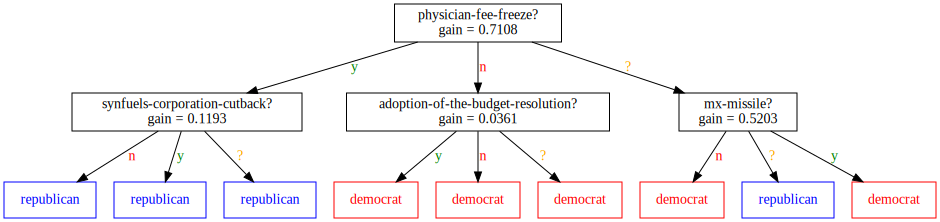

In [10]:
DT.visualize_party_classification()

In [11]:
y_pred = DT.predict(X_test)
(y_pred == y_test.reset_index(drop=True)).value_counts()

True     80
False     3
dtype: int64

In [12]:
y_pred_train = DT.predict(X_train)
(y_pred_train == y_train.reset_index(drop=True)).value_counts()

True     318
False     14
dtype: int64

### 2.2.2 A Priori Classifier

In [13]:
class APrioriClassifier:
    """
    Dummy Classifier not considering any X data.
    """   
    def __init__(self, method="mode"):
        """
        Instantiates the classifier.
        """
        if method != "mode":
            raise Exception("Invalid method. Accepted values are [\"mode\"].")
        self._method = method
        self._decision = None

    def _dummy_decision(self, y):
        if self._method == "mode":
            return y.mode()[0]
        else:
            raise Exception("Invalid method. Accepted values are [\"mode\"].")
            
    def fit(self, X, y):
        """
        Classifier based only on y-value's mode of the train data
        """
        self._decision = self._dummy_decision(y)
        
    def predict(self,X):
        if self._decision is None:
                raise Exception("The model was not trained yet. Run fit method first.")
        y_predicted = []
        for index in X.index:
            y_predicted.append(self._decision)
        return pd.Series(y_predicted)
        

In [14]:
APC = APrioriClassifier()
APC.fit(X_train, y_train)

In [15]:
y_pred_APC = APC.predict(X_test)
(y_pred_APC == y_test.reset_index(drop=True)).value_counts()

True     47
False    36
dtype: int64

In [16]:
y_pred_APCtrain = APC.predict(X_train)
(y_pred_APCtrain == y_train.reset_index(drop=True)).value_counts()

True     210
False    122
dtype: int64

## 2.3 Comparison

#### 2.3.1 Accuracy Rate

In [17]:
# A Priori Classifier
y_predict_apc = APC.predict(X_test)
accuracy_apc = (y_predict_apc == y_test.reset_index(drop=True))
accuracy_apc = accuracy_apc.sum() / len(accuracy_apc)
print(f"The accuracy of the a priori classifier was {accuracy_apc*100:.2f}%")

# Decision Tree Classifier
y_predict_dt = DT.predict(X_test)
accuracy_dt = (y_predict_dt == y_test.reset_index(drop=True))
accuracy_dt = accuracy_dt.sum() / len(accuracy_dt)
print(f"The accuracy of the decision tree classifier was {accuracy_dt*100:.2f}%")

The accuracy of the a priori classifier was 56.63%
The accuracy of the decision tree classifier was 96.39%


#### 2.3.2 Confusion Matrix

In [18]:
labels = ['democrat', 'republican']

# A Priori Classifier
confusion_matrix_apc = confusion_matrix(y_true=y_test.reset_index(drop=True), y_pred=y_predict_apc)
plt.figure()
ax = sns.heatmap(confusion_matrix_apc, 
                 annot=True, 
                 xticklabels=labels, 
                 yticklabels=labels,
                 cmap=sns.color_palette("Reds", 8))
ax.set(xlabel="Predicted label", 
       ylabel="Right label",
       title="A priori")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.savefig("confusion_matrix_a_priori.png", bbox_inches='tight', dpi=300)
plt.close()

# Decision Tree Classifier
confusion_matrix_dt = confusion_matrix(y_true=y_test.reset_index(drop=True), y_pred=y_predict_dt)
plt.figure()
ax = sns.heatmap(confusion_matrix_dt, 
                 annot=True, 
                 xticklabels=labels, 
                 yticklabels=labels,
                 cmap=sns.color_palette("Blues", 8))
ax.set(xlabel="Predicted label",
       ylabel="Right label",
       title="Árvore de decisão")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.get_figure().savefig("confusion_matrix_decision_tree.png", bbox_inches='tight', dpi=300)
plt.close()

#### 2.3.3 Mean Squared Error (MSE)

In [19]:
# A Priori Classifier
mse_apc = (y_predict_apc != y_test.reset_index(drop=True))
mse_apc = mse_apc.sum() / len(mse_apc)
print(f"The MSE of the a priori classifier was {mse_apc*100:.2f}%")

# Decision Tree Classifier
mse_dt = (y_predict_dt != y_test.reset_index(drop=True))
mse_dt = mse_dt.sum() / len(mse_dt)
print(f"The MSE of the decision tree classifier was {mse_dt*100:.2f}%")

The MSE of the a priori classifier was 43.37%
The MSE of the decision tree classifier was 3.61%


#### 2.3.4 Kappa Coefficient

For binary classifications, the Kappa Coefficient can be written as

$$
k = \frac{2 \times (TP \times TN - FN \times FP)}{(TP + FP) \times (FP + TN) + (TP + FN) \times (FN + TN)},
$$
where TP are the true positives, FP are the false positives, TN are the true negatives, and FN are the false negatives.

In [20]:
def get_binary_kappa(confusion_matrix):
    """
    Evaluate the Kappa coefficient for binary classifications.

    :arg confusion_matrix: The confusion matrix of the classifier.
    :type confusion_matrix: A 2x2 matrix.
    :return: Kappa coefficient.
    :return type: Float.
    """
    tp = confusion_matrix[1][1]
    tn = confusion_matrix[0][0]
    fn = confusion_matrix[1][0]
    fp = confusion_matrix[0][1]
    kappa = (2 * (tp * tn - fn * fp)) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))
    return kappa

In [21]:
kappa_apc = get_binary_kappa(confusion_matrix_apc)
kappa_dt = get_binary_kappa(confusion_matrix_dt)
print(f"Kappa coefficient for the a priori classifier: {kappa_apc:.4f}")
print(f"Kappa coefficient for the decision tree classifier: {kappa_dt:.4f}")

Kappa coefficient for the a priori classifier: 0.0000
Kappa coefficient for the decision tree classifier: 0.9271


Or we can use sklearn

In [22]:
kappa_apc = cohen_kappa_score(y_test.reset_index(drop=True), y_predict_apc)
kappa_dt = cohen_kappa_score(y_test.reset_index(drop=True), y_predict_dt)
print(f"Kappa coefficient for the a priori classifier: {kappa_apc:.4f}")
print(f"Kappa coefficient for the decision tree classifier: {kappa_dt:.4f}")

Kappa coefficient for the a priori classifier: 0.0000
Kappa coefficient for the decision tree classifier: 0.9271


#### 2.4 Improve Decision Tree Classifier

#### 2.4.1 Hyperparameter tuning (Maximum depth)

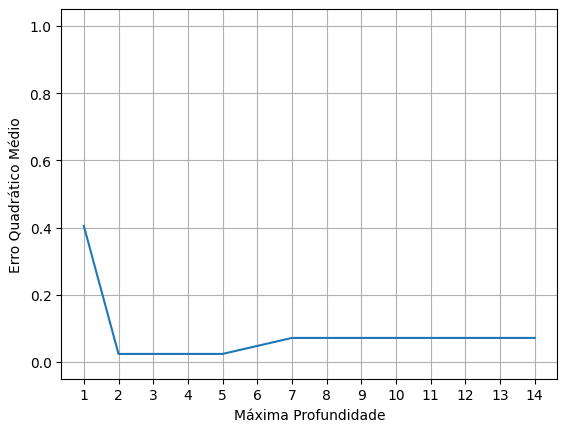

In [23]:
MAX_DEPTH = X_test.shape[1] + 1

x_tunning_test = X_test.iloc[0:X_test.shape[0] // 2]
y_tunning_test = y_test.iloc[0:X_test.shape[0] // 2]
x_tunning_cross_validation = X_test.iloc[X_test.shape[0] // 2:]
y_tunning_cross_validation = y_test.iloc[X_test.shape[0] // 2:]

mse_all = []
for depth in range(1, MAX_DEPTH):
    current_DT = DecisionTreeClassifier(max_depth=depth)
    current_DT.fit(X_train, y_train)
    y_predict = current_DT.predict(x_tunning_cross_validation)
    mse = (y_predict != y_tunning_cross_validation.reset_index(drop=True))
    mse = mse.sum() / len(mse)
    mse_all.append(mse)

plt.plot(range(1, MAX_DEPTH), mse_all)
plt.xlabel('Máxima Profundidade')
plt.ylabel('Erro Quadrático Médio')
plt.ylim(-0.05, 1.05)
plt.xticks(range(1, MAX_DEPTH))
plt.grid()
plt.savefig('max_depth_tunning.png', dpi=300)